In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.utils import plot_model
from keras.layers import  LSTM, RepeatVector, TimeDistributed, Dropout
from sklearn import metrics
import seaborn as sns
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
data=pd.read_csv("Book.csv")

In [3]:
data.shape

(43956, 23)

In [4]:
(18-7)*24*60*60/43956

21.62162162162162

In [5]:
22*5/60


1.8333333333333333

In [6]:
v=sorted(data['Time'])

In [7]:
set((v==data['Time']))

{True}

In [8]:
price=data['Price']

In [9]:
del data['Price']

In [10]:
del data['Time']

In [11]:
data.shape

(43956, 21)

In [12]:
def split_sequences(Xt,yt,step ,look_back, horizon):
    X, y = list(), list()
    for i in range(0,len(Xt),step):
        end_ix = i + look_back
        out_end_ix = end_ix + horizon-1
        if out_end_ix > len(Xt)-1:
            break
        seq_x, seq_y = Xt[i:end_ix], yt[out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    X,y=np.array(X), np.array(y)
    return X,y

In [13]:
def train_test_split(data,train_size=0.9,look_back = 128,horizon=15,step=50,scale=True):
    split_idx = int(data.shape[0]*train_size)
    data=data.values
    X_train = data[:split_idx, :-1]
    y_train = data[:split_idx, -1]
    X_test = data[split_idx:, :-1]
    y_test = data[split_idx:, -1]
    
    if scale:
        scalerX = StandardScaler().fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
    
    X_train,y_train=split_sequences(X_train,y_train,step,look_back,horizon)
    X_test,y_test=split_sequences(X_test,y_test,step,look_back,horizon)

    

   
    
    
    return X_train,y_train,X_test,y_test

In [14]:
k=pd.DataFrame(np.arange(1,31).reshape((-1,3)))

In [15]:
a,b,c,d=train_test_split(k,0.9,3,2,2,False)

In [16]:
k

,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9
3,10,11,12
4,13,14,15
5,16,17,18
6,19,20,21
7,22,23,24
8,25,26,27
9,28,29,30


In [17]:
a

array([[[ 1,  2],
        [ 4,  5],
        [ 7,  8]],

       [[ 7,  8],
        [10, 11],
        [13, 14]],

       [[13, 14],
        [16, 17],
        [19, 20]]])

In [18]:
b

array([15, 21, 27])

In [19]:
X_train,y_train,X_test,y_test=train_test_split(data,train_size=0.9,look_back = 50,horizon=5,step=1,scale=True)

In [20]:
label_train=y_train+1

In [21]:
label_test=y_test+1

(array([11186.,     0.,     0.,     0.,     0., 16837.,     0.,     0.,
            0., 11483.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

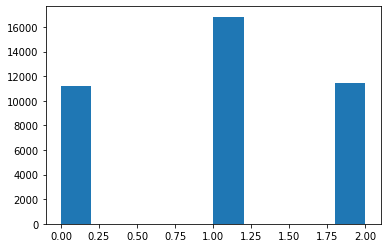

In [22]:
plt.hist(label_train)

(array([1535.,    0.,    0.,    0.,    0., 1275.,    0.,    0.,    0.,
        1532.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

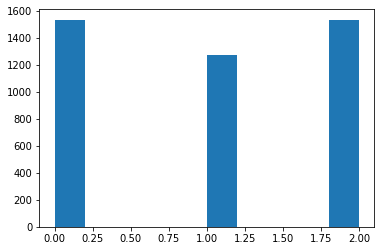

In [23]:
plt.hist(label_test)

In [24]:
y_train=to_categorical(label_train)

In [25]:
y_test=to_categorical(label_test)

In [26]:
#valsize=int(X_test.shape[0]*0.1)

In [27]:
#valx=X_test[:valsize]
#valy=y_test[:valsize]
#X_test=X_test[valsize:]
#y_test=y_test[valsize:]

In [28]:
X_train.shape

(39506, 50, 20)

In [29]:
y_train.shape

(39506, 3)

In [30]:
X_test.shape

(4342, 50, 20)

In [31]:
y_test.shape

(4342, 3)

In [32]:
input_shape=(X_train.shape[1],X_train.shape[2])

In [33]:
input_shape

(50, 20)

CNN


In [34]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=input_shape))
model_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(3,activation="softmax"))
model_cnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 49, 16)            656       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               76900     
_________________________________________________________________
dense_2 (Dense)              (None, 3)               

In [74]:
verbose, epochs, batch_size = 1,1000,32
checkpoint="cnn1.model"

early_stopping = EarlyStopping(patience=11, verbose=verbose,monitor='val_acc')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=verbose,monitor='loss')
model_checkpoint = ModelCheckpoint(checkpoint, save_best_only=True, verbose=verbose,monitor='val_acc')

In [75]:
opt=Adam(lr=0.001)#'categorical_crossentropy'
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history=model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,verbose=verbose, validation_data=(X_test,y_test),callbacks=[early_stopping,model_checkpoint, reduce_lr])

Train on 39506 samples, validate on 4342 samples
Epoch 1/1000
39506/39506 [==============================] - 23s 592us/step - loss: 1.0810 - acc: 0.4271 - val_loss: 1.1116 - val_acc: 0.2936

Epoch 00001: val_acc improved from -inf to 0.29364, saving model to cnn1.model
Epoch 2/1000
39506/39506 [==============================] - 17s 419us/step - loss: 1.0686 - acc: 0.4364 - val_loss: 1.1034 - val_acc: 0.3277

Epoch 00002: val_acc improved from 0.29364 to 0.32773, saving model to cnn1.model
Epoch 3/1000
39506/39506 [==============================] - 17s 421us/step - loss: 1.0631 - acc: 0.4442 - val_loss: 1.0979 - val_acc: 0.3418

Epoch 00003: val_acc improved from 0.32773 to 0.34178, saving model to cnn1.model
Epoch 4/1000
39506/39506 [==============================] - 17s 424us/step - loss: 1.0501 - acc: 0.4589 - val_loss: 1.0780 - val_acc: 0.3989

Epoch 00004: val_acc improved from 0.34178 to 0.39889, saving model to cnn1.model
Epoch 5/1000
39506/39506 [==============================] 

<IPython.core.display.Javascript object>


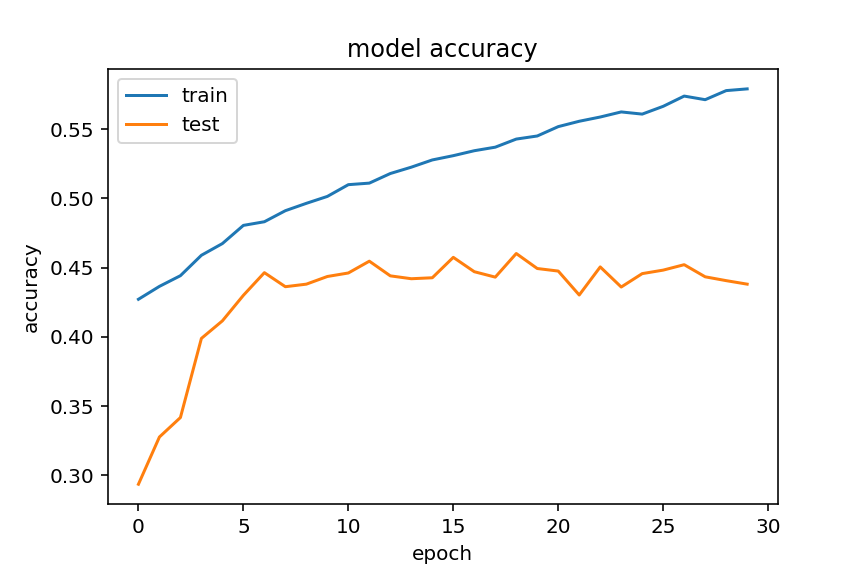

In [125]:
%matplotlib notebook
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


<IPython.core.display.Javascript object>


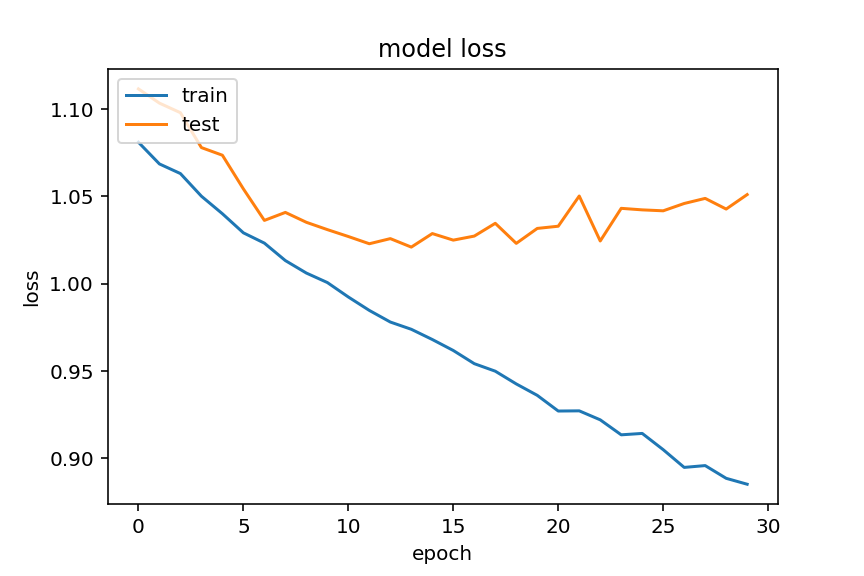

In [126]:
# summarize history for loss
%matplotlib notebook
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
cn=pd.DataFrame(history.history)
cn.to_csv("cnnhistory.csv")

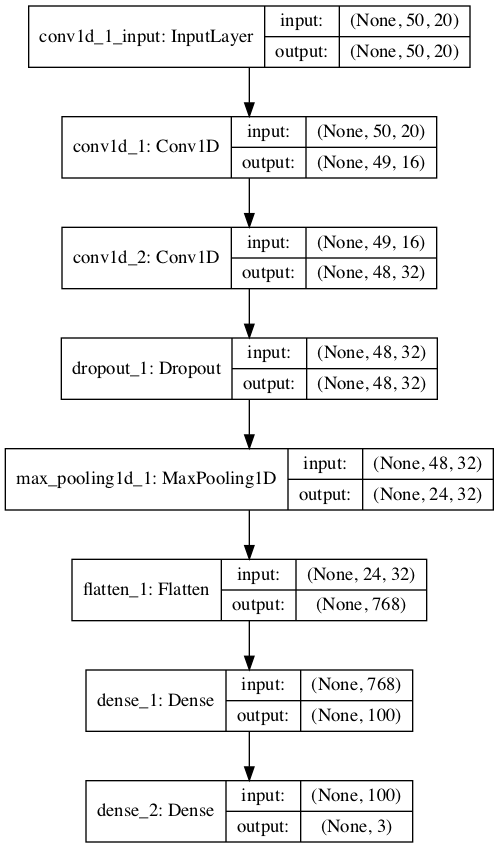

In [67]:
plot_model(model_cnn,to_file='model_cnn.png',show_shapes=True)

In [35]:
model_cnn.load_weights("cnn1.model")

In [36]:
opt=Adam(lr=0.01)
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [37]:
ac=model_cnn.evaluate(X_test, y_test,verbose=0)[1]
print("CNN model accuracy:" +str(ac))


CNN model accuracy:0.4661446213722229


In [38]:
predcnn=model_cnn.predict_classes(X_test)

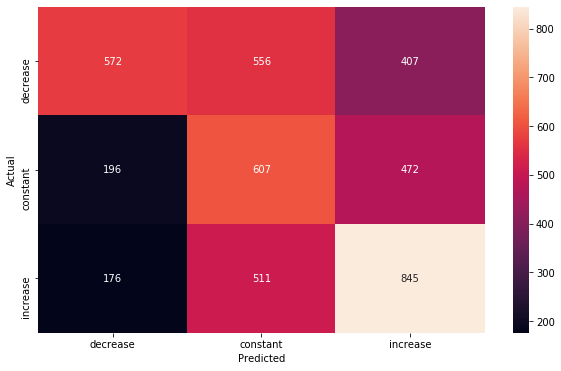

In [39]:

cm =confusion_matrix(label_test, predcnn)  
index = ['decrease','constant','increase']  
columns = ['decrease','constant','increase']   
cm_df = pd.DataFrame(cm,columns,index)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d")

In [44]:
print(classification_report(label_test, predcnn,target_names=['decrease','constant','increase']))

              precision    recall  f1-score   support

    decrease       0.61      0.37      0.46      1535
    constant       0.36      0.48      0.41      1275
    increase       0.49      0.55      0.52      1532

    accuracy                           0.47      4342
   macro avg       0.49      0.47      0.46      4342
weighted avg       0.49      0.47      0.47      4342



LSTM

In [46]:
model_lstm = Sequential()#return_sequences=True
model_lstm.add(LSTM(50, activation='relu' ,input_shape=input_shape))
model_lstm.add(Dense(3,activation="softmax"))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                14200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 14,353
Trainable params: 14,353
Non-trainable params: 0
_________________________________________________________________


In [99]:
verbose, epochs, batch_size = 1,1000,128
checkpoint="lstm1.model"

early_stopping = EarlyStopping(patience=10, verbose=verbose,monitor='val_acc')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=verbose,monitor='loss')
model_checkpoint = ModelCheckpoint(checkpoint, save_best_only=True, verbose=verbose,monitor='val_acc')

In [102]:
opt=Adam(lr=0.01)#'categorical_crossentropy'CategoricalAccuracy()
model_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
history_lstm=model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,verbose=verbose, validation_data=(X_test,y_test),callbacks=[early_stopping,model_checkpoint, reduce_lr])

Train on 39506 samples, validate on 4342 samples
Epoch 1/1000
39506/39506 [==============================] - 41s 1ms/step - loss: 2.1930 - acc: 0.4248 - val_loss: 1.0837 - val_acc: 0.4030

Epoch 00001: val_acc improved from 0.35007 to 0.40304, saving model to lstm1.model
Epoch 2/1000
39506/39506 [==============================] - 40s 1ms/step - loss: 1.0639 - acc: 0.4659 - val_loss: 1.0361 - val_acc: 0.4436

Epoch 00002: val_acc improved from 0.40304 to 0.44357, saving model to lstm1.model
Epoch 3/1000
39506/39506 [==============================] - 40s 1ms/step - loss: 1.0441 - acc: 0.4864 - val_loss: 1.0071 - val_acc: 0.4599

Epoch 00003: val_acc improved from 0.44357 to 0.45993, saving model to lstm1.model
Epoch 4/1000
39506/39506 [==============================] - 40s 1ms/step - loss: 1.0249 - acc: 0.4903 - val_loss: 0.9851 - val_acc: 0.4694

Epoch 00004: val_acc improved from 0.45993 to 0.46937, saving model to lstm1.model
Epoch 5/1000
39506/39506 [==============================] -

<IPython.core.display.Javascript object>


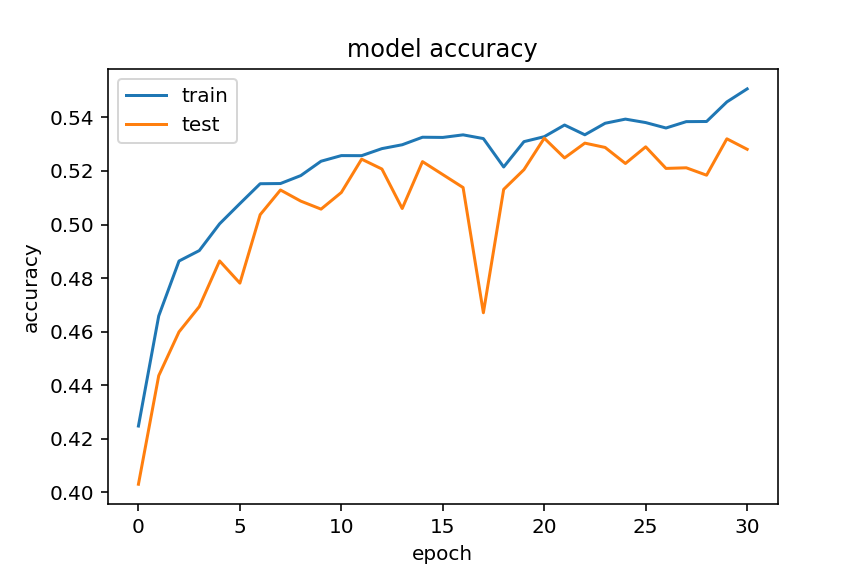

In [133]:
%matplotlib notebook
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



<IPython.core.display.Javascript object>


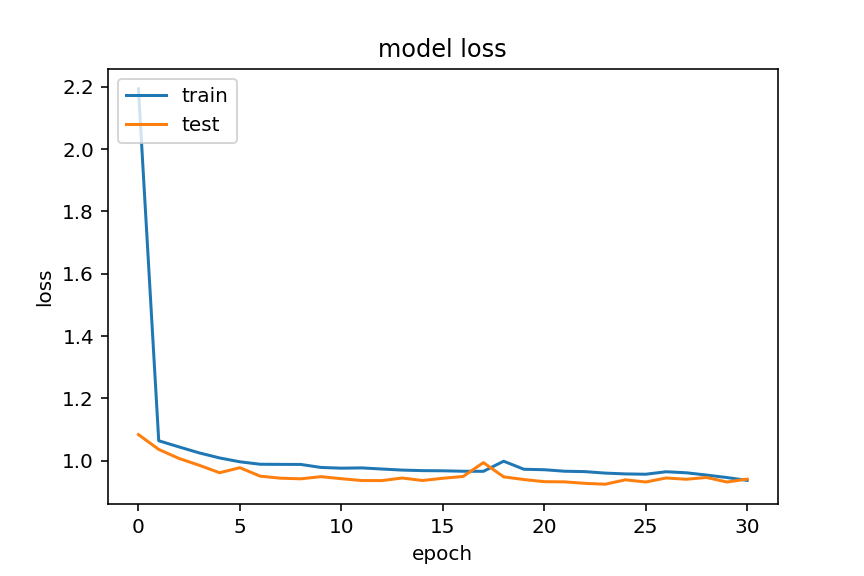

In [134]:
# summarize history for loss
%matplotlib notebook
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [135]:
ls=pd.DataFrame(history_lstm.history)
ls.to_csv("lstmhistory.csv")

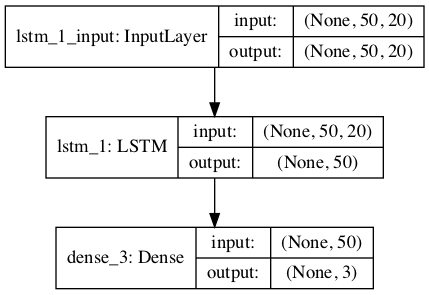

In [95]:
plot_model(model_lstm,to_file='model_lstm.png',show_shapes=True)

In [47]:
model_lstm.load_weights("lstm1.model")

In [48]:
opt=Adam(lr=0.01)
model_lstm.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [49]:
ac=model_lstm.evaluate(X_test, y_test,verbose=0)[1]
print("LSTM model accuracy:" +str(ac))

LSTM model accuracy:0.4997696876525879


In [50]:
predlstm=model_lstm.predict_classes(X_test)

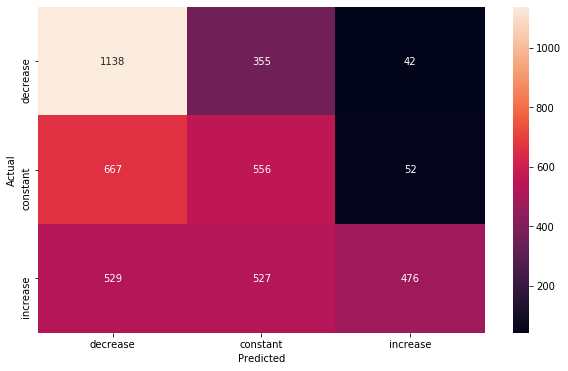

In [51]:

cm =confusion_matrix(label_test, predlstm)  
index = ['decrease','constant','increase']  
columns = ['decrease','constant','increase']   
cm_df = pd.DataFrame(cm,columns,index) 
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d")

In [52]:
print(classification_report(label_test, predlstm,target_names=['decrease','constant','increase']))

              precision    recall  f1-score   support

    decrease       0.49      0.74      0.59      1535
    constant       0.39      0.44      0.41      1275
    increase       0.84      0.31      0.45      1532

    accuracy                           0.50      4342
   macro avg       0.57      0.50      0.48      4342
weighted avg       0.58      0.50      0.49      4342

